In [19]:
import sys
sys.path.append("../")

import pandas as pd
import os
import numpy as np

from library import regulations
from library import analysis
from library import tables
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt


In [3]:
data_path = '/Users/kylieleblancKylie/domino/dofis/data/'
table_path = '/Users/kylieleblancKylie/domino/dofis/results/descriptive/'
data = pd.read_csv(os.path.join(data_path, 'clean', 'master_data_district.csv'),
                  sep=",")
data.sample(5)

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,year,district,distname,distischarter,rating_academic,rating_financial,type,type_description,cntyname,...,district_status,type_urban,type_suburban,type_town,type_rural,eligible,teachers_nodegree,teachers_badegree,teachers_msdegree,teachers_phddegree
6187,6187,2017,15907,SAN ANTONIO ISD,N,M,Pass,A,MAJOR URBAN,BEXAR,...,doi,1,0,0,0,1,0.001550,0.678084,0.318196,0.00217
3943,3943,2015,57813,TRINITY BASIN PREPARATORY,Y,M,Pass,I,CHARTER SCHOOL DISTRICTS,DALLAS,...,charter,0,0,0,0,0,0.050645,0.868324,0.081031,0.00000
3906,3906,2015,47902,DE LEON ISD,N,M,Pass,H,RURAL,COMANCHE,...,doi,0,0,0,1,1,0.000000,0.826620,0.173380,0.00000
4779,4779,2015,227821,AUSTIN DISCOVERY SCHOOL,Y,M,Pass,I,CHARTER SCHOOL DISTRICTS,TRAVIS,...,charter,0,0,0,0,0,0.000000,0.688482,0.311518,0.00000
4461,4461,2015,152903,SLATON ISD,N,M,Pass,G,NON-METROPOLITAN STABLE,LUBBOCK,...,doi,0,0,1,0,1,0.000000,0.792769,0.207231,0.00000


In [4]:
print(data.students_white.hist())

AxesSubplot(0.125,0.11;0.775x0.77)


In [5]:
data = data[data.year == 2016]
data = data[data.doi == True]
data.sample(5)

,Unnamed: 0,year,district,distname,distischarter,rating_academic,rating_financial,type,type_description,cntyname,...,district_status,type_urban,type_suburban,type_town,type_rural,eligible,teachers_nodegree,teachers_badegree,teachers_msdegree,teachers_phddegree
5187,5187,2016,57906,DESOTO ISD,N,M,Pass,B,MAJOR SUBURBAN,DALLAS,...,doi,0,1,0,0,1,0.010758,0.628851,0.344091,0.016300
5855,5855,2016,196902,WOODSBORO ISD,N,M,Pass,H,RURAL,REFUGIO,...,doi,0,0,0,1,1,0.000000,0.890869,0.111359,0.000000
5676,5676,2016,153904,TAHOKA ISD,N,M,Pass,H,RURAL,LYNN,...,doi,0,0,0,1,1,0.001724,0.894828,0.103448,0.000000
5349,5349,2016,91909,WHITESBORO ISD,N,M,Pass,D,OTHER CENTRAL CITY SUBURBAN,GRAYSON,...,doi,0,1,0,0,1,0.000000,0.710744,0.289256,0.000000
5514,5514,2016,111903,TOLAR ISD,N,M,Pass,E,INDEPENDENT TOWN,HOOD,...,doi,0,0,1,0,1,0.000000,0.888333,0.110000,0.001667


# Student Demographics

In [6]:
bins = [0, .2, .4, .6, .8,1]
labels = [.2, .4, .6,.8,1]
data['bins_hispanic']  = pd.cut(data['students_hisp'], bins, labels = labels)
data[['students_hisp', 'bins_hispanic']].sample(5)
data['bin20'] = np.where(data.bins_hispanic == .2, 1, 0)
data['bin40'] = np.where(data.bins_hispanic == .4, 1, 0)
data['bin60'] = np.where(data.bins_hispanic == .6, 1, 0)
data['bin80'] = np.where(data.bins_hispanic == .8, 1, 0)
data['bin100'] = np.where(data.bins_hispanic == 1, 1, 0)

In [7]:
len(data)

822

In [8]:
data.bins_hispanic.value_counts()

0.2    273
0.4    240
0.6    162
0.8     88
1.0     59
Name: bins_hispanic, dtype: int64

In [9]:
def create_count_proportion_df(data, list_of_regs):
    n_col = []
    p_20 = []
    p_40 = []
    p_60 = []
    p_80 = []
    p_100 = []
    reg_labels = []
    f_p = []

    for reg in list_of_regs:
        n_col.append((len(data[data[reg] == 1])))
        p_20.append(data[data.bins_hispanic == .2][reg].mean().round(2))
        p_40.append(data[data.bins_hispanic == .4][reg].mean().round(2))
        p_60.append(data[data.bins_hispanic == .6][reg].mean().round(2))
        p_80.append(data[data.bins_hispanic == .8][reg].mean().round(2))
        p_100.append(data[data.bins_hispanic == 1][reg].mean().round(2))
        reg_labels.append(regulations.labels[reg])
        formula = reg + '~ bin40 + bin60 + bin80 + bin100'
        df = data.dropna(subset=['students_hisp', reg])
        results = smf.ols(formula, data=df).fit()
        f_p.append(results.f_pvalue.round(2))

    df = pd.DataFrame(
            {'Regulation': reg_labels,
             'Count': n_col,
             '<20% Hispanic': p_20,
              '20% - 40%': p_40,
             '40% - 60%': p_60,
             '60% - 80%': p_80,
             '>80% Hispanic': p_100,
             'F-test p-value': f_p
             })
    return df

In [10]:
columns = ['Count', '<20% Hispanic', '20% - 40%', '40% - 60%', '60% - 80%', '>80% Hispanic', 'F-test p-value']
schedules_df = create_count_proportion_df(data, list_of_regs = regulations.schedules)
tables.df_to_excel(file = table_path + 'desc_exemptionsXdemographics.xlsx', df = schedules_df,
                  df_columns = columns, start_row = 5, start_col = 3)
schedules_df

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


,Regulation,Count,<20% Hispanic,20% - 40%,40% - 60%,60% - 80%,>80% Hispanic,F-test p-value
0,25.0811 - Minimum First Day of Instruction,798,0.98,0.98,0.97,0.97,0.90,0.01
1,25.081 - Minimum Minutes of Operation,356,0.37,0.48,0.48,0.50,0.31,0.01
2,25.0812 - Minimum Last Day of Instruction,231,0.27,0.26,0.31,0.33,0.27,0.68
3,25.082 - Pledge of Allegiance and Minute of Si...,208,0.25,0.29,0.24,0.30,0.10,0.04


In [11]:
class_size_df = create_count_proportion_df(data, list_of_regs = regulations.class_size)
tables.df_to_excel(file = table_path + 'desc_exemptionsXdemographics.xlsx', df = class_size_df,
                  df_columns = columns, start_row = 10, start_col = 3)
class_size_df

,Regulation,Count,<20% Hispanic,20% - 40%,40% - 60%,60% - 80%,>80% Hispanic,F-test p-value
0,25.112 - Class Size Maximum,363,0.48,0.42,0.46,0.40,0.39,0.52
1,25.113 - Notice of Class Size,299,0.41,0.36,0.37,0.27,0.31,0.18
2,25.111 - Maximum Student Teacher Ratio,127,0.14,0.15,0.20,0.17,0.08,0.27


In [12]:
certification_df = create_count_proportion_df(data, 
                                                 list_of_regs = regulations.certification)
tables.df_to_excel(file = table_path + 'desc_exemptionsXdemographics.xlsx', df = certification_df,
                  df_columns = columns, start_row = 14, start_col = 3)
certification_df

,Regulation,Count,<20% Hispanic,20% - 40%,40% - 60%,60% - 80%,>80% Hispanic,F-test p-value
0,21.003 - Teacher Certification Required,714,0.87,0.88,0.90,0.89,0.71,0.01
1,21.053 - Presentation of Teacher Certificates,240,0.28,0.28,0.35,0.27,0.27,0.58
2,21.057 - Notice of Uncertified Teacher,271,0.36,0.34,0.34,0.23,0.25,0.12


In [13]:
contracts_df = create_count_proportion_df(data, 
                                                 list_of_regs = regulations.contracts)
tables.df_to_excel(file = table_path + 'desc_exemptionsXdemographics.xlsx', df = contracts_df,
                  df_columns = columns, start_row = 18, start_col = 3)
contracts_df

,Regulation,Count,<20% Hispanic,20% - 40%,40% - 60%,60% - 80%,>80% Hispanic,F-test p-value
0,21.102 - Maximum Probationary Contract Length,419,0.58,0.52,0.48,0.47,0.31,0.00
1,21.401 - Minimum Service Days Required for Tea...,290,0.39,0.34,0.34,0.39,0.24,0.22
2,21.352 - Teacher Evaluation,166,0.21,0.22,0.15,0.22,0.22,0.46
3,21.354 - Administrator Evaluation,46,0.04,0.07,0.04,0.09,0.05,0.30


In [14]:
behavior_df = create_count_proportion_df(data, 
                                                 list_of_regs = regulations.behavior)
tables.df_to_excel(file = table_path + 'desc_exemptionsXdemographics.xlsx', df = behavior_df,
                  df_columns = columns, start_row = 23, start_col = 3)
behavior_df

,Regulation,Count,<20% Hispanic,20% - 40%,40% - 60%,60% - 80%,>80% Hispanic,F-test p-value
0,25.092 - Minimum Attendance for Class Credit,214,0.16,0.32,0.31,0.27,0.32,0.00
1,37.0012 - Designation of Campus Behavior Coord...,178,0.17,0.24,0.24,0.28,0.17,0.11
2,25.036 - Transfers,178,0.26,0.22,0.20,0.16,0.14,0.13


# Scatter Plots

In [25]:
bins = [0, .05, .10, .15, .20, .25, .30, .35, .40, .45, .50, .55, .60, .65, .70, .75, .80, .85, .90, .95, 1]
labels = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
data['bins']  = pd.cut(data['students_hisp'], bins, labels = labels)

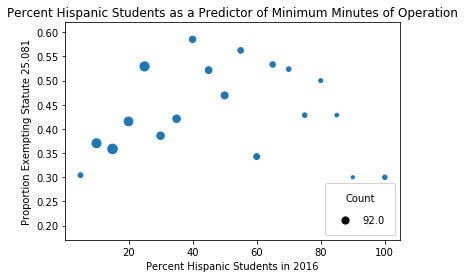

In [32]:
df = data[['bins', 'reg25_081']].groupby('bins')['reg25_081'].describe().reset_index().rename(columns = {'mean': 'p'})
plt.scatter(df.bins, df.p, s = df['count'])

plt.ylabel('Proportion Exempting Statute 25.081')
plt.xlabel('Percent Hispanic Students in 2016')
plt.title('Percent Hispanic Students as a Predictor of Minimum Minutes of Operation')

pws = (pd.cut(df['count'], bins=4, retbins=True)[1]).round(0)
for pw in pws:
    plt.scatter([], [], s=df['count'], c="k",label=str(pw))

h, l = plt.gca().get_legend_handles_labels()
plt.legend(h[5:], l[5:], labelspacing=1.2, title="Count", borderpad=1, 
            frameon=True, framealpha=0.9, loc=4, numpoints=1)

plt.gca()

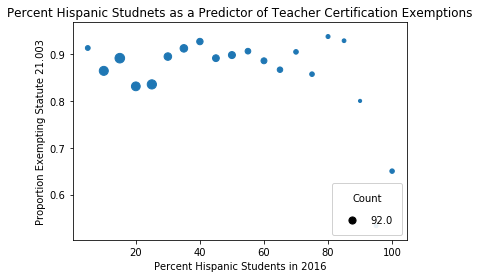

In [33]:
df = data[['bins', 'reg21_003']].groupby('bins')['reg21_003'].describe().reset_index().rename(columns = {'mean': 'p'})
plt.scatter(df.bins, df.p, s = df['count'])

plt.ylabel('Proportion Exempting Statute 21.003')
plt.xlabel('Percent Hispanic Students in 2016')
plt.title('Percent Hispanic Studnets as a Predictor of Teacher Certification Exemptions')

pws = (pd.cut(df['count'], bins=4, retbins=True)[1]).round(0)
for pw in pws:
    plt.scatter([], [], s=df['count'], c="k",label=str(pw))

h, l = plt.gca().get_legend_handles_labels()
plt.legend(h[5:], l[5:], labelspacing=1.2, title="Count", borderpad=1, 
            frameon=True, framealpha=0.9, loc=4, numpoints=1)

plt.gca()

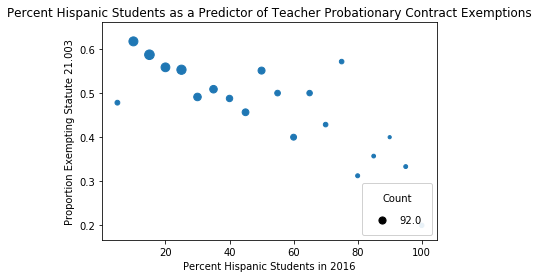

In [34]:
df = data[['bins', 'reg21_102']].groupby('bins')['reg21_102'].describe().reset_index().rename(columns = {'mean': 'p'})
plt.scatter(df.bins, df.p, s = df['count'])

plt.ylabel('Proportion Exempting Statute 21.003')
plt.xlabel('Percent Hispanic Students in 2016')
plt.title('Percent Hispanic Students as a Predictor of Teacher Probationary Contract Exemptions')

pws = (pd.cut(df['count'], bins=4, retbins=True)[1]).round(0)
for pw in pws:
    plt.scatter([], [], s=df['count'], c="k",label=str(pw))

h, l = plt.gca().get_legend_handles_labels()
plt.legend(h[5:], l[5:], labelspacing=1.2, title="Count", borderpad=1, 
            frameon=True, framealpha=0.9, loc=4, numpoints=1)

plt.gca()

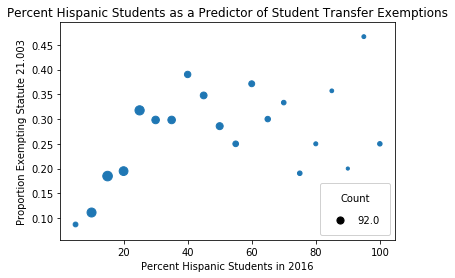

In [35]:
df = data[['bins', 'reg25_092']].groupby('bins')['reg25_092'].describe().reset_index().rename(columns = {'mean': 'p'})
plt.scatter(df.bins, df.p, s = df['count'])

plt.ylabel('Proportion Exempting Statute 21.003')
plt.xlabel('Percent Hispanic Students in 2016')
plt.title('Percent Hispanic Students as a Predictor of Student Transfer Exemptions')

pws = (pd.cut(df['count'], bins=4, retbins=True)[1]).round(0)
for pw in pws:
    plt.scatter([], [], s=df['count'], c="k",label=str(pw))

h, l = plt.gca().get_legend_handles_labels()
plt.legend(h[5:], l[5:], labelspacing=1.2, title="Count", borderpad=1, 
            frameon=True, framealpha=0.9, loc=4, numpoints=1)

plt.gca()